In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/ecommerce-events-history-in-cosmetics-shop/2020-Feb.csv')

In [26]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-02-01 00:00:01 UTC,cart,5844305,1487580006317032337,NaN,NaN,2.14,485174092,4be9643a-420b-4c6b-83dd-a15e772fbf7a
1,2020-02-01 00:00:03 UTC,view,5769925,1487580013841613016,NaN,kapous,4.22,594621622,a88baf11-9cd0-4362-bde4-1bfeed3f641d
2,2020-02-01 00:00:08 UTC,view,5817765,1487580008246412266,NaN,zeitun,11.03,495404942,3a569c8d-d848-4f09-a925-33f673d84c46
3,2020-02-01 00:00:11 UTC,view,5877033,1487580010100293687,NaN,milv,3.49,564814969,7feb39e5-bb7b-4b2b-a546-3e3b7c56326e
4,2020-02-01 00:00:12 UTC,cart,5814871,1487580008112194531,NaN,zinger,2.54,551205603,106a7c7f-7fa1-4463-8bec-0ea7b02191cb


In [54]:
df.shape

(4156682, 10)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156682 entries, 0 to 4156681
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 285.4+ MB


In [2]:
# Unique counts
unique_user_id = df['user_id'].nunique()
unique_product_id = df['product_id'].nunique()
unique_category = df['category_id'].nunique()

# Count of all event_type rows (not distinct, but total count as in SQL COUNT(event_type))
unique_event_type = df['event_type'].count()

# Put in dictionary or dataframe
result = {
    "unique_user_id": unique_user_id,
    "unique_product_id": unique_product_id,
    "unique_category": unique_category,
    "unique_event_type": unique_event_type
}

print(result)

{'unique_user_id': 391055, 'unique_product_id': 48579, 'unique_category': 487, 'unique_event_type': 4156682}


In [3]:
df.isnull().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    4079497
brand            1825908
price                  0
user_id                0
user_session        1055
dtype: int64

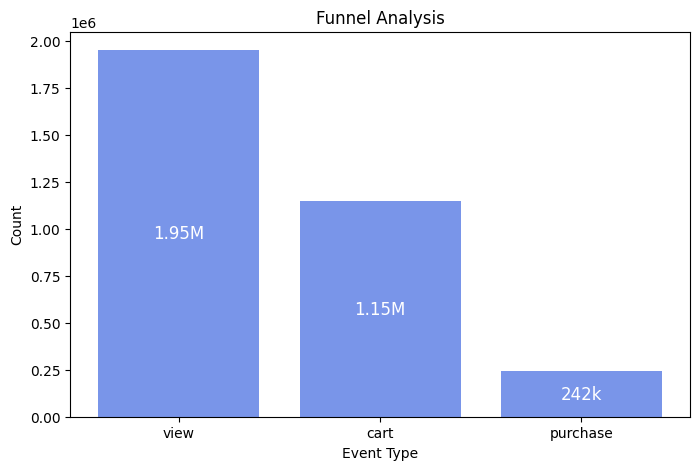

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate event counts in the desired order
event_order = ['view', 'cart', 'purchase']
event_counts = df['event_type'].value_counts().reindex(event_order).fillna(0)

# Plot funnel-like bar chart
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(event_counts.index, event_counts.values, color='royalblue', alpha=0.7)

# Add count labels on the bars
for bar in bars:
    height = bar.get_height()
    if height >= 1_000_000:
        label = f"{height/1_000_000:.2f}M"
    elif height >= 1_000:
        label = f"{height/1_000:.0f}k"
    else:
        label = f"{int(height)}"
    ax.text(bar.get_x() + bar.get_width() / 2, height * 0.5, label, ha='center', va='center', color='white', fontsize=12)

ax.set_title('Funnel Analysis')
ax.set_ylabel('Count')
ax.set_xlabel('Event Type')

plt.show()


In [5]:
import pandas as pd

# Group by user_id and aggregate event types
customer_behavior = (
    df.groupby("user_id")["event_type"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Add total customer behaviors
customer_behavior["customer_behaviors"] = (
    customer_behavior[["view", "cart", "remove_from_cart", "purchase"]].sum(axis=1)
)

# Order by customer_behaviors desc
customer_behavior = customer_behavior.sort_values("customer_behaviors", ascending=False)

print(customer_behavior.head())

event_type    user_id  cart  purchase  remove_from_cart  view  \
20735       419558969  2991         0              4132   155   
28532       445777038  3749         0              1662     0   
198578      609977037  1927         0              3329    33   
98624       562226472  1918         0              2996    23   
121916      583070980  1594        39              2230   452   

event_type  customer_behaviors  
20735                     7278  
28532                     5411  
198578                    5289  
98624                     4937  
121916                    4315  


In [6]:
number_of_purchase = df.loc[df["event_type"] == "purchase", "user_id"].nunique()
print("Number of users who purchased:", number_of_purchase)

Number of users who purchased: 25759


In [10]:
# If you want total rows (like SQL COUNT(user_id))
number_of_visit = df["user_id"].count()

# If you want unique visitors (recommended for conversion rate)
unique_visitors = (df["event_type"] == "purchase").sum()

print("Number of visits (rows):", number_of_visit)
print("Unique visitors:", unique_visitors)

Number of visits (rows): 4156682
Unique visitors: 241993


In [14]:
conversion_rate = unique_visitors / number_of_visit
print("Conversion rate:", round(conversion_rate, 4))
print("Conversion Percentage:", round(conversion_rate*100, 2))

Conversion rate: 0.0582
Conversion Percentage: 5.82


In [15]:
#print("Total purchase rows:", (df["event_type"] == "purchase").sum())
#print("Unique purchasing users:", df.loc[df["event_type"]=="purchase", "user_id"].nunique())

In [16]:
# Step 1: Rebuild customer_behaviors (if not already built)
customer_behaviors = (
    df.groupby("user_id")["event_type"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 2: total views from users with view>0 and purchase=0
total_view = customer_behaviors.loc[
    (customer_behaviors["view"] > 0) & (customer_behaviors["purchase"] == 0),
    "view"
].sum()

# Step 3: views from users with view>0, cart=0, purchase=0
not_add_to_cart = customer_behaviors.loc[
    (customer_behaviors["view"] > 0) &
    (customer_behaviors["cart"] == 0) &
    (customer_behaviors["purchase"] == 0),
    "view"
].sum()

# Final result
result = {
    "total_view": total_view,
    "not_add_to_cart": not_add_to_cart
}

print(result)

{'total_view': 1314918, 'not_add_to_cart': 702712}


In [20]:
churn_rate_1 = not_add_to_cart/total_view
print('Churn Rate:',round(churn_rate_1*100,2))

Churn Rate: 53.44


In [19]:
# Step 1: total add-to-cart actions (sum of cart column)
total_add_to_cart = customer_behaviors["cart"].sum()

# Step 2: add-to-cart actions from users who never purchased
total_not_purchase = customer_behaviors.loc[
    (customer_behaviors["cart"] > 0) & (customer_behaviors["purchase"] == 0),
    "cart"
].sum()

# Final result
result = {
    "total_add_to_cart": total_add_to_cart,
    "total_not_purchase": total_not_purchase
}

print(result)

{'total_add_to_cart': 1148694, 'total_not_purchase': 605448}


In [21]:
churn_rate_2 = total_not_purchase/total_add_to_cart
print('Churn Rate:',round(churn_rate_2*100,2))

Churn Rate: 52.71


In [22]:
# Step 1: total add-to-cart actions (same as before)
total_add_to_cart = customer_behaviors["cart"].sum()

# Step 2: total remove_from_cart for users with cart>0 and purchase=0
total_remove_from_cart = customer_behaviors.loc[
    (customer_behaviors["cart"] > 0) & (customer_behaviors["purchase"] == 0),
    "remove_from_cart"
].sum()

# Final result
result = {
    "total_add_to_cart": total_add_to_cart,
    "total_remove_from_cart": total_remove_from_cart
}

print(result)

{'total_add_to_cart': 1148694, 'total_remove_from_cart': 390604}


In [24]:
churn_rate_3 = total_remove_from_cart/total_add_to_cart
print('Churn Rate:',round(churn_rate_3*100,2))

Churn Rate: 34.0


In [25]:
# Step 1: rebuild customer_behaviors (if not already done)
customer_behaviors = (
    df.groupby("user_id")["event_type"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 2: Funnel metrics

# Views from users who viewed but not purchased
total_view = customer_behaviors.loc[
    (customer_behaviors["view"] > 0) & (customer_behaviors["purchase"] == 0),
    "view"
].sum()

# Views but never carted or purchased
not_add_to_cart = customer_behaviors.loc[
    (customer_behaviors["view"] > 0) &
    (customer_behaviors["cart"] == 0) &
    (customer_behaviors["purchase"] == 0),
    "view"
].sum()

# Total add-to-cart
total_add_to_cart = customer_behaviors["cart"].sum()

# Add-to-cart but never purchased
not_purchase_cart = customer_behaviors.loc[
    (customer_behaviors["cart"] > 0) & (customer_behaviors["purchase"] == 0),
    "cart"
].sum()

# Remove-from-cart (for users who added to cart but didn’t purchase)
total_remove_from_cart = customer_behaviors.loc[
    (customer_behaviors["cart"] > 0) & (customer_behaviors["purchase"] == 0),
    "remove_from_cart"
].sum()

# Total purchases (row count of purchase events)
total_purchase = (df["event_type"] == "purchase").sum()

# Step 3: Build funnel DataFrame
funnel = pd.DataFrame([
    {"Stage": "View (non-purchasers)", "Count": total_view},
    {"Stage": "Views but not added to cart", "Count": not_add_to_cart},
    {"Stage": "Add to Cart (all)", "Count": total_add_to_cart},
    {"Stage": "Add to Cart but not purchased", "Count": not_purchase_cart},
    {"Stage": "Remove from Cart (non-purchasers)", "Count": total_remove_from_cart},
    {"Stage": "Purchase", "Count": total_purchase},
])

print(funnel)

                               Stage    Count
0              View (non-purchasers)  1314918
1        Views but not added to cart   702712
2                  Add to Cart (all)  1148694
3      Add to Cart but not purchased   605448
4  Remove from Cart (non-purchasers)   390604
5                           Purchase   241993


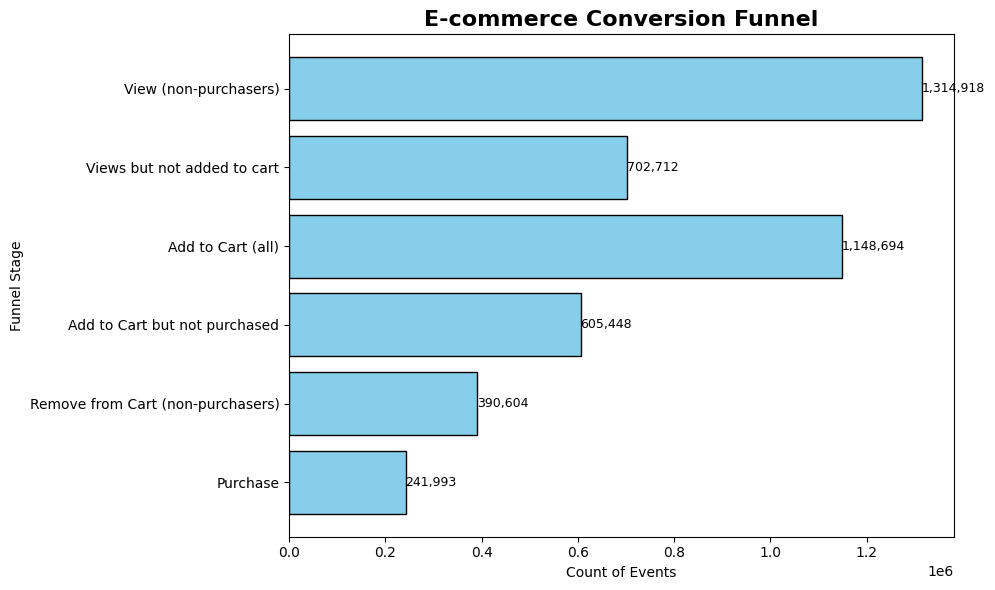

In [29]:
import matplotlib.pyplot as plt

# Sort stages in funnel order (top → bottom)
funnel_order = [
    "View (non-purchasers)",
    "Views but not added to cart",
    "Add to Cart (all)",
    "Add to Cart but not purchased",
    "Remove from Cart (non-purchasers)",
    "Purchase"
]
funnel = funnel.set_index("Stage").loc[funnel_order].reset_index()

# Plot horizontal funnel chart
plt.figure(figsize=(10,6))
plt.barh(funnel["Stage"], funnel["Count"], color="skyblue", edgecolor="black")

# Invert y-axis so the first stage is at the top
plt.gca().invert_yaxis()

# Add labels
for i, val in enumerate(funnel["Count"]):
    plt.text(val, i, f"{val:,}", va="center", ha="left", fontsize=9)

plt.title("E-commerce Conversion Funnel", fontsize=16, fontweight="bold")
plt.xlabel("Count of Events")
plt.ylabel("Funnel Stage")
plt.tight_layout()
plt.show()


## Hypothesis 1

In [30]:
# Step 1: Build per-product views
product_views = (
    df.loc[df["event_type"] == "view"]
    .groupby("product_id")
    .size()
    .reset_index(name="total_view")
)

# Step 2: Sort and take top 100
top_100_viewed_products = product_views.sort_values(
    "total_view", ascending=False
).head(100)

print(top_100_viewed_products.head())

       product_id  total_view
17243     5809910       17774
16881     5808664       16678
44536     5924482        7801
17245     5809912        5427
26875     5850281        4742


In [32]:
# Step 1: Top 100 most purchased products
product_purchases = (
    df.loc[df["event_type"] == "purchase"]
    .groupby("product_id")
    .size()
    .reset_index(name="total_purchase")
)

top_100_purchased_products = product_purchases.sort_values(
    "total_purchase", ascending=False
).head(100)

# Step 2: Find common product_ids
common_products = pd.merge(
    top_100_viewed_products,
    top_100_purchased_products,
    on="product_id",
    how="inner"
)

# Step 3: Count common product_ids
common_product_count = common_products["product_id"].nunique()

print("Common products between top viewed and purchased:", common_product_count)
print("\nList of common products:\n", common_products)

Common products between top viewed and purchased: 31

List of common products:
     product_id  total_view  total_purchase
0      5809910       17774            1412
1      5924482        7801             214
2      5809912        5427             544
3      5751383        4399             497
4      5790563        4326             205
5      5849033        3789             511
6      5751422        3544             597
7      5816170        3463             383
8      5809911        3181             325
9      5815662        2791             659
10     5814046        2294             229
11     5792800        2287             423
12     5528035        2259             352
13     5700037        2178             682
14     5854812        2017             232
15     5816166        1967             203
16     5862943        1798             355
17     5802432        1659             691
18     5789668        1651             232
19     5854897        1564             915
20     5833334   

## Hypothesis 2

In [38]:
# 1. Count how many times each product was purchased
product_purchase_counts = (
    df[df["event_type"] == "purchase"]
    .groupby("product_id")
    .size()
    .reset_index(name="event_purchase")
)

# 2. Total unique products purchased
total_products_purchased = product_purchase_counts.shape[0]

# 3. Products purchased at least 2 times
products_2plus = product_purchase_counts[product_purchase_counts["event_purchase"] >= 2]
repeat_product_count = products_2plus.shape[0]

# 4. Repeat Purchase Rate
repeat_product_rate = repeat_product_count / total_products_purchased

print("Total unique products purchased:", total_products_purchased)
print("Products purchased 2+ times:", repeat_product_count)
print("Repeat Purchase Rate (Products):", round(repeat_product_rate * 100, 2), "%")


Total unique products purchased: 28515
Products purchased 2+ times: 20482
Repeat Purchase Rate (Products): 71.83 %


## Customer Behaviour Path

In [39]:
import pandas as pd

# 1. Convert event_time column to datetime
df["event_time"] = pd.to_datetime(df["event_time"])

# 2. Filter only 'view' events
views_df = df[df["event_type"] == "view"]

# 3. Extract date (YYYYMMDD format)
views_df["days"] = views_df["event_time"].dt.strftime("%Y%m%d")

# 4. Count number of user_id per day
daily_views = (
    views_df.groupby("days")["user_id"]
    .count()
    .reset_index(name="total_count")
    .sort_values("days")
)

print(daily_views.head())


       days  total_count
0  20200201        68524
1  20200202        72677
2  20200203        80059
3  20200204        75035
4  20200205        73018


/tmp/ipykernel_36/2888613365.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  views_df["days"] = views_df["event_time"].dt.strftime("%Y%m%d")


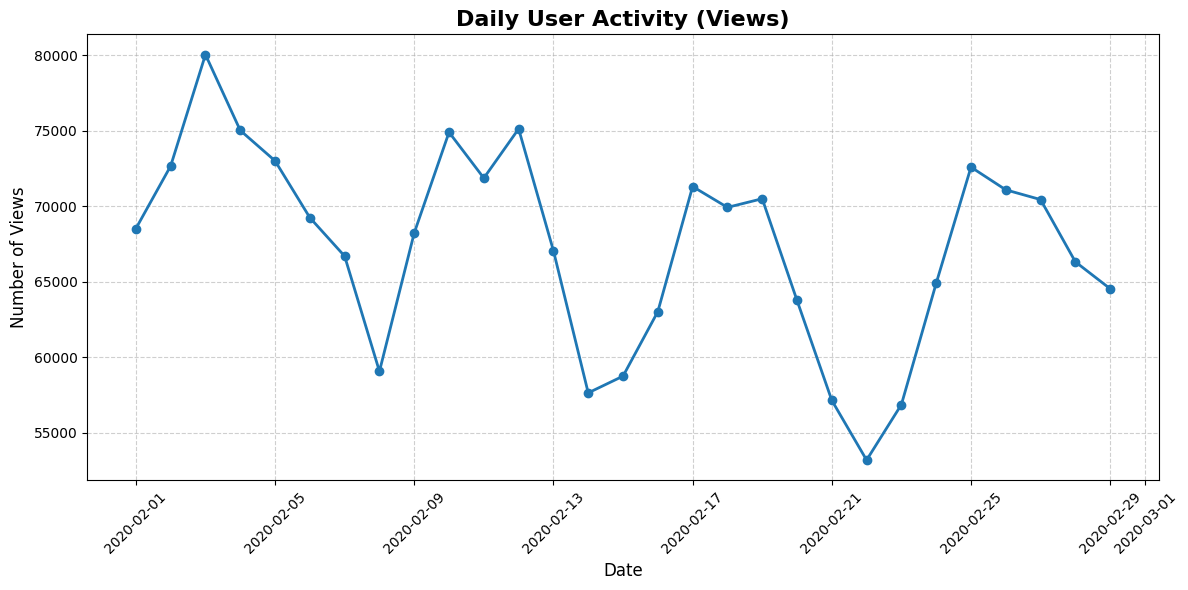

In [40]:
import matplotlib.pyplot as plt

# Plot daily views as a time series
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(daily_views["days"]), daily_views["total_count"], marker="o", linewidth=2)

# Beautify the chart
plt.title("Daily User Activity (Views)", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Views", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

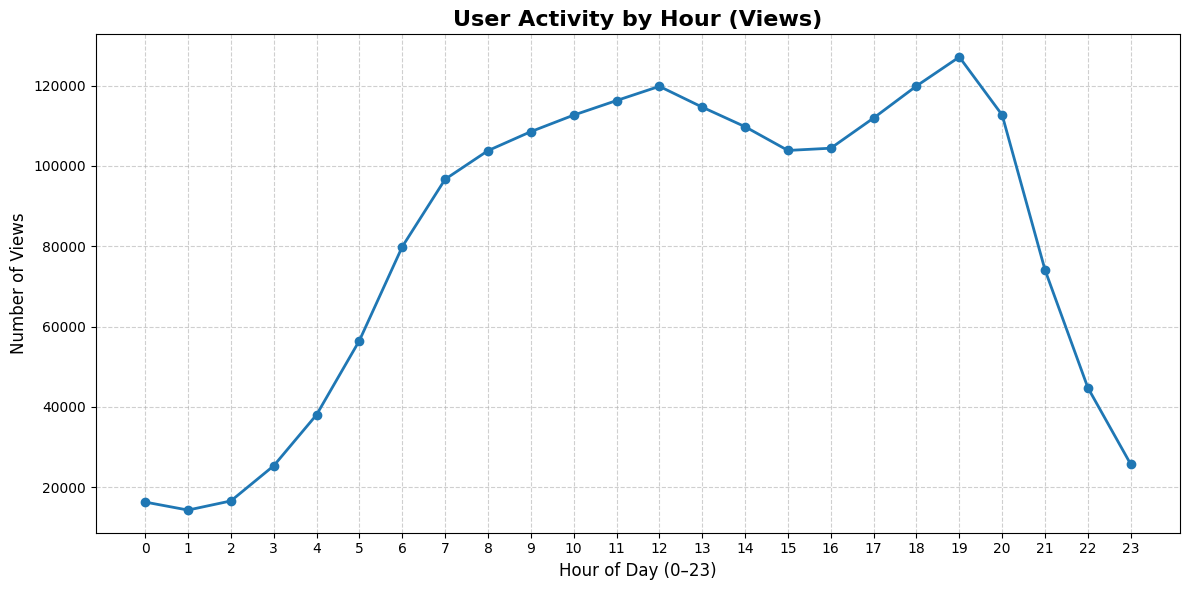

In [41]:
# Extract hour from event_time
df["event_time"] = pd.to_datetime(df["event_time"])
df["hour"] = df["event_time"].dt.hour

# Aggregate views by hour
hourly_views = (
    df[df["event_type"] == "view"]
    .groupby("hour")["user_id"]
    .count()
    .reset_index(name="total_count")
    .sort_values("hour")
)

# Plot
plt.figure(figsize=(12,6))
plt.plot(hourly_views["hour"], hourly_views["total_count"], marker="o", linewidth=2)

plt.title("User Activity by Hour (Views)", fontsize=16, fontweight="bold")
plt.xlabel("Hour of Day (0–23)", fontsize=12)
plt.ylabel("Number of Views", fontsize=12)
plt.xticks(range(0,24))
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


## How each product contributes to business

In [42]:
product_interactions = (
    df.groupby("product_id")["user_id"]
    .count()
    .reset_index(name="total_count")
    .sort_values("total_count", ascending=False)
)

print(product_interactions.head(10))

       product_id  total_count
18043     5809910        27555
17669     5808664        16760
18045     5809912         9990
7346      5700037         9705
29711     5854897         9643
16566     5802432         9358
46553     5924482         9146
19689     5815662         8595
10864     5751383         7866
10902     5751422         7386


In [43]:
# Count views per product
views_per_product = (
    df[df["event_type"] == "view"]
    .groupby("product_id")["user_id"]
    .count()
    .reset_index(name="views")
)

# Count purchases per product
purchases_per_product = (
    df[df["event_type"] == "purchase"]
    .groupby("product_id")["user_id"]
    .count()
    .reset_index(name="purchases")
)

# Merge
product_conversion = pd.merge(views_per_product, purchases_per_product, on="product_id", how="inner")

# Calculate conversion rate
product_conversion["conversion_rate"] = product_conversion["purchases"] / product_conversion["views"]

# Sort by highest conversion
product_conversion = product_conversion.sort_values("conversion_rate", ascending=False)

print(product_conversion.head(10))

       product_id  views  purchases  conversion_rate
3246      5685888      1          7         7.000000
2652      5670722      1          7         7.000000
19523     5866151      1          7         7.000000
24080     5899513      1          6         6.000000
2397      5659914      2         11         5.500000
23544     5894916      3         16         5.333333
19525     5866153      1          5         5.000000
13209     5826641      1          5         5.000000
22499     5886318      1          5         5.000000
3519      5691610      1          5         5.000000


In [44]:
# Filter purchase events
purchase_df = df[df["event_type"] == "purchase"]

# Count purchases per product_id
product_purchase_counts = (
    purchase_df.groupby("product_id")["user_id"]
    .count()
    .reset_index(name="purchase_times")
)

# Group by purchase_times (how many times each product was bought)
purchase_distribution = (
    product_purchase_counts.groupby("purchase_times")["product_id"]
    .count()
    .reset_index(name="total_purchase_count")
    .sort_values("purchase_times")
)

print(purchase_distribution.head(10))


   purchase_times  total_purchase_count
0               1                  8033
1               2                  4566
2               3                  2991
3               4                  2091
4               5                  1564
5               6                  1180
6               7                   988
7               8                   755
8               9                   635
9              10                   515


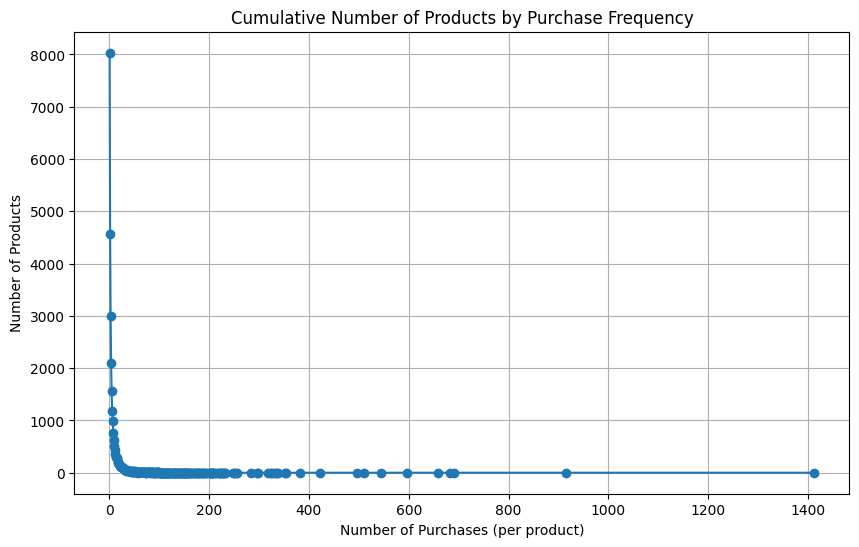

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(
    purchase_distribution["purchase_times"],
    purchase_distribution["total_purchase_count"],
    marker="o"
)
plt.title("Cumulative Number of Products by Purchase Frequency")
plt.xlabel("Number of Purchases (per product)")
plt.ylabel("Number of Products")
plt.grid(True)
plt.show()

In [46]:
# Filter only purchase events
purchase_df = df[df["event_type"] == "purchase"]

# Count purchases per category_id
category_purchase_counts = (
    purchase_df.groupby("category_id")["user_id"]
    .count()
    .reset_index(name="purchase_times")
)

# Group by purchase_times (how many times each category was bought)
category_purchase_distribution = (
    category_purchase_counts.groupby("purchase_times")["category_id"]
    .count()
    .reset_index(name="total_purchase_count")
    .sort_values("purchase_times")
)

print(category_purchase_distribution.head(10))


   purchase_times  total_purchase_count
0               1                    10
1               2                     3
2               3                     2
3               4                     6
4               5                     2
5               6                     3
6               7                     2
7               8                     2
8               9                     3
9              10                     2


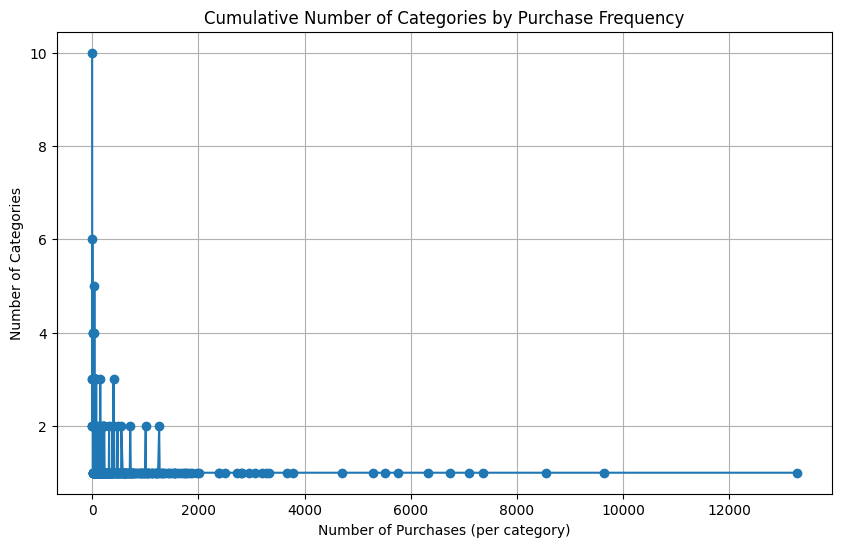

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(
    category_purchase_distribution["purchase_times"],
    category_purchase_distribution["total_purchase_count"],
    marker="o",
    linestyle="-"
)
plt.title("Cumulative Number of Categories by Purchase Frequency")
plt.xlabel("Number of Purchases (per category)")
plt.ylabel("Number of Categories")
plt.grid(True)
plt.show()


## Who are the most valuable customers

In [48]:
# Filter purchase events
purchase_df = df[df["event_type"] == "purchase"]

# Count purchases per user
customer_purchase_counts = (
    purchase_df.groupby("user_id")["event_type"]
    .count()
    .reset_index(name="total_count")
    .sort_values("total_count", ascending=False)
)

print(customer_purchase_counts.head(10))  # top 10 customers

         user_id  total_count
15265  601469771          461
5309   480463194          338
24590  620029655          324
8528   538580192          285
11978  573823111          268
11156  566439116          240
12813  582804703          231
9363   548209402          222
5728   491009486          219
6942   516204225          218


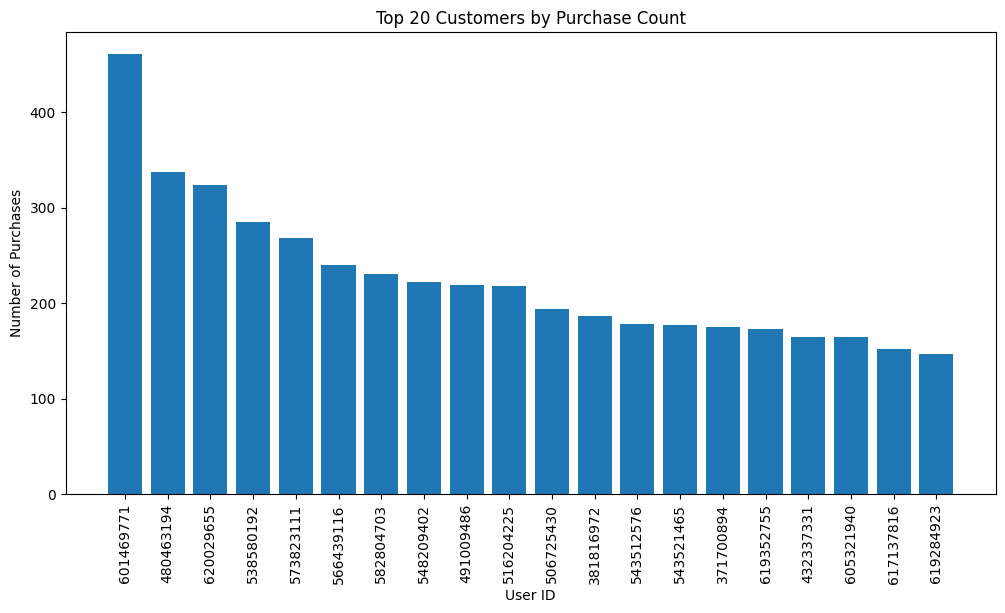

In [49]:
import matplotlib.pyplot as plt

top_customers = customer_purchase_counts.head(20)

plt.figure(figsize=(12,6))
plt.bar(top_customers["user_id"].astype(str), top_customers["total_count"])
plt.xticks(rotation=90)
plt.title("Top 20 Customers by Purchase Count")
plt.xlabel("User ID")
plt.ylabel("Number of Purchases")
plt.show()


In [50]:
# Filter purchases for the specific user
user_id = 601469771
user_purchases = df[(df["event_type"] == "purchase") & (df["user_id"] == user_id)]

# Count purchases by product
favorite_products = (
    user_purchases.groupby("product_id")["user_id"]
    .count()
    .reset_index(name="total_purchase")
    .sort_values("total_purchase", ascending=False)
)

print(favorite_products.head(10))  # Top 10 favorite products


     product_id  total_purchase
0          4540               1
317     5869068               1
315     5868911               1
314     5868907               1
313     5868906               1
312     5868905               1
311     5868904               1
310     5868902               1
309     5868901               1
308     5868899               1


In [52]:
# Filter purchases for the specific user
user_id = 601469771
user_category_purchases = df[(df["event_type"] == "purchase") & (df["user_id"] == user_id)]

# Count purchases by category
favorite_categories = (
    user_category_purchases.groupby("category_id")["user_id"]
    .count()
    .reset_index(name="total_purchase")
    .sort_values("total_purchase", ascending=False)
)

print(favorite_categories.head(10))  # Top 10 categories

            category_id  total_purchase
8   1487580007575323592              98
26  1487580010796548183              67
10  1487580007675986893              51
11  1487580007717929935              39
43  2018395024110125980              34
42  1897124478404526487              25
27  1487580010821714008              21
9   1487580007634043851              20
7   1487580007550157767              17
21  1487580009471148064              12


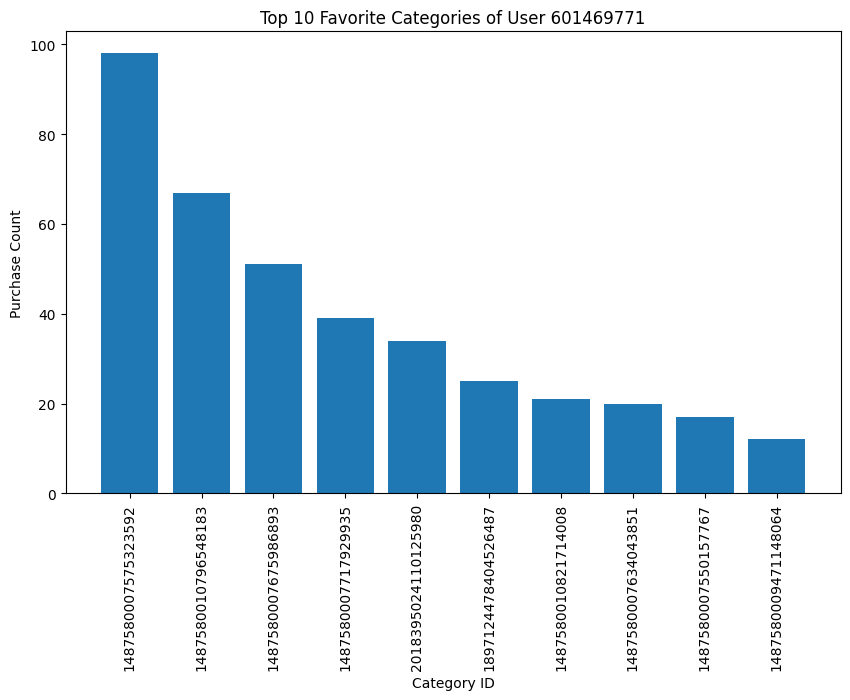

In [53]:
import matplotlib.pyplot as plt

top_categories = favorite_categories.head(10)

plt.figure(figsize=(10,6))
plt.bar(top_categories["category_id"].astype(str), top_categories["total_purchase"])
plt.xticks(rotation=90)
plt.title(f"Top 10 Favorite Categories of User {user_id}")
plt.xlabel("Category ID")
plt.ylabel("Purchase Count")
plt.show()